In [2]:
#================================================= IMPORTS =============================================
import numpy as np 
import pandas as pd 
import os
import numpy as np
import math
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import matplotlib.pyplot as plt

from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
inn = 4
k = 4
s = 1
p = 0

op = 0

print('conv', (inn - k + 2*p)//s + 1)

print('T conv', (inn-1)*s-2*p+(k-1)+op+1)

In [3]:
#============================================== Conditional Deep Convolutional Wasserstein GAN ========================================
class cWGAN_Generator(nn.Module):
    def __init__(self, latent_dim, num_labels):
        super().__init__()
        self.linear_projection = nn.Linear(latent_dim+num_labels, 4*4*512)
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1), #8*8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), #16*16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), #32*32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1), #64*64
            nn.Tanh()
            )
    def forward(self, x, labels):
        x = torch.cat((x, labels), dim=1)
        x = self.linear_projection(x)
        x = x.reshape(-1, 512, 4, 4)
        x = self.layers(x)
        return x
    
class cWGAN_Critic(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.num_labels = num_labels
        self.layers = nn.Sequential(
            nn.Conv2d(3+num_labels, 64, kernel_size=3, stride=2, padding=1), #32*32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #16*16
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), #8*8
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), #8*8
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1), #4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0), #1*1,
            )
        
    def forward(self, x, labels):
        bs = labels.size(dim=0)
        y = labels.reshape(-1, self.num_labels, 1, 1)
        x = torch.cat((x, y* (torch.ones(size=(bs, 1, 64, 64)).to("cuda:0"))), dim = 1)
        x = self.layers(x)
        return x 

In [ ]:
test_csv = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')[0:2]
test_csv.shape[0]

In [ ]:
a = [1,2,3,4,5,6]
b = [1 if el < 4 else 0 for el in a]
torch.tensor(b)

In [4]:
# ======================================== Dataset and Dataloader ===================================
root_dir = '/kaggle/input/celeba-dataset/'
img_prefix = 'img_align_celeba/img_align_celeba/'
csv_name = 'list_attr_celeba.csv'

image_size = 64
data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

class CelebA_Dataset(Dataset):
    def __init__(self,
                 labels,
                 root_dir = root_dir,
                 csv_name = csv_name, 
                 img_prefix = img_prefix, 
                 is_train = True, 
                 transform = data_transform):
        self.root_dir = root_dir
        self.img_prefix = img_prefix
        self.labels = labels
        if is_train:
            self.csv = pd.read_csv(root_dir+csv_name)[0:182637]
        else:
            self.csv = pd.read_csv(root_dir+csv_name)[182637:]
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        img_name = self.csv.iloc[index]['image_id']
        labels = [1 if self.csv.iloc[index][label] == 1 else 0 for label in self.labels]
        image = Image.open(self.root_dir + self.img_prefix + img_name).convert('RGB')
        image_tensor = self.transform(image)
        image.close()
        return image_tensor, torch.tensor(labels)

In [5]:
labels = ['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Eyeglasses', 'Heavy_Makeup', 'Male', 'Pale_Skin', 'Smiling'] 

In [6]:
train_CelebA = CelebA_Dataset(labels)
test_CelebA = CelebA_Dataset(labels, is_train=False)

dataloaders = dict()
dataloaders['train'] = DataLoader(train_CelebA,
                                  batch_size=64,
                                  shuffle=True,
                                  num_workers=2,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['test'] = DataLoader(test_CelebA,
                                 batch_size=64,
                                 shuffle=True,
                                 num_workers=2,
                                 pin_memory=True)

In [7]:
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx DEVICE xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# =========================================  Gradient penalty =====================================
def compute_gradient_penalty(Critic, real_samples, fake_samples, labels, device):
    # Random weight term for interpolation between real and fake samples
    epsilon = torch.tensor(np.random.random((real_samples.size(0), 1, 1, 1)), dtype=torch.float32).to(device)
    # Get random interpolation between real and fake samples
    x_hat = (epsilon * real_samples + ((1 - epsilon) * fake_samples)).requires_grad_(True)
    score_xhat = Critic(x_hat, labels)
    fake = torch.ones(size=(real_samples.shape[0],1, 1, 1), dtype=torch.float32).to(device)
    fake.requires_grad = False
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=score_xhat,
        inputs=x_hat,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [9]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3, outdir=None, epoch=1):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    if not outdir is None:
        plt.savefig(f'{outdir}results_for_epoch_{epoch}')
    plt.close()

In [ ]:
imgs_dist1 = torch.randint(0, 200, (32, 3, 64, 64), dtype=torch.uint8).to(device)
show_tensor_images(imgs_dist1, num_images=16, size=(3, 64, 64), nrow=3, outdir=None, epoch=1)

In [10]:
def plot_epoch_stats(metrics, epoch_inf, m_name, out_dir = None):
    mets = list(metrics.keys())
    
    fig, axs = plt.subplots(4)
    fig.suptitle(f'Metrics for epoch {epoch_inf[0]}/{epoch_inf[1]+1} ||{m_name}||')
    for idx, m in enumerate(mets):
        axs[idx].plot(range(1, epoch_inf[0]+1), metrics[m], label=f'{m}')
        axs[idx].set(xlabel='epochs', ylabel=f'{m}')
        #axs[idx].set_title(f'{m}')
        axs[idx].legend(loc="center right")
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    if not out_dir is None:
        plt.savefig(f'{out_dir}stats_for_epoch_{epoch_inf[0]}')
        
    plt.close('all')

In [11]:
def train_GAN(generator, 
              critic,
              latent_dims,
              gp_coeff,
              optim_G, 
              optim_C, 
              dataloader,
              device,
              n_epochs=100, 
              n_critic=5, 
              prev_metrics=None, 
              save_every=None, 
              fig_dir=None, 
              w_dir=None):
    #===============
    #Previous metrics
    metrics = ['FID', 'IS', 'W_Score_G', 'W_Dist_C']
    start_epoch = 1
    if prev_metrics is None:
        saved_metrics = {metric: list() for metric in metrics}
    else:
        saved_metrics = prev_metrics
        start_epoch = len(saved_metrics['FID'])+1
        
    IS = InceptionScore(normalize=True)
    FID = FrechetInceptionDistance(feature=64, normalize=True)
    
    print("="*100)
    print(f"Starting GAN training with params:")
    print(f'Generator net: {generator.name}')
    print(f"Generator otimizer: {optim_G}")
    print(f'Critic net: {critic.name}')
    print(f"Critic otimizer: {optim_C}")
    print(f"Criterion: Critic Score & Wasserstein distance + Gradient penalty")
    
    epoch_cnt = 0
    # +++++++++++++++++++++++++++ Epoch
    for epoch in range(start_epoch, start_epoch+n_epochs):
        start_time = time.time()
        
        mean_W_Score_G = 0
        mean_W_Dist_C = 0
        mean_FID = 0
        mean_IS = 0
        
        cur_tqdm = tqdm(dataloader['train'])
        batch_cnt = 0
        gen_cnt = 0
        # +++++++++++++++ Batches
        for imgs, labels in cur_tqdm:
            bs = imgs.shape[0]
            batch_cnt += 1
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            # xxxxxxxxx Train Critic
            optim_C.zero_grad()
            
            z = torch.tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dims)), dtype=torch.float32).to(device)
            gen_imgs = generator(z, labels)
            
            real_score = critic(imgs, labels)
            gen_score = critic(gen_imgs, labels)
            
            #========= Wasserstein distance + GP
            gradient_penalty = compute_gradient_penalty(critic, imgs, gen_imgs, labels, device)
            Wasserstein_distance = -torch.mean(real_score) + torch.mean(gen_score) + gp_coeff * gradient_penalty
            mean_W_Dist_C += Wasserstein_distance.item()
            Wasserstein_distance.backward()
            optim_C.step()
            
            #xxxxxxxxx Train Generator every n_critic steps
            optim_G.zero_grad()
            
            if batch_cnt % n_critic == 0:
                # === Generate imgs
                gen_imgs = generator(z, labels)
                # === Score
                gen_score = critic(gen_imgs, labels)
                # === Add to mean
                W_Score_G = -torch.mean(gen_score)
                mean_W_Score_G += W_Score_G.item()
                W_Score_G.backward()
                optim_G.step()
                gen_cnt += 1
            #xxxxxxxxxx
        
        end_time = time.time()
        epoch_time = end_time - start_time
        mean_W_Score_G = mean_W_Score_G / gen_cnt
        saved_metrics['W_Score_G'].append(mean_W_Score_G)
        mean_W_Dist_C =  mean_W_Dist_C / batch_cnt
        saved_metrics['W_Dist_C'].append(mean_W_Dist_C)
        
        imgs, labels = next(iter(dataloader['test']))
        imgs = imgs[:16].to(device)
        labels = labels[:16].to(device)
        z = torch.tensor(np.random.normal(0, 1, (16, latent_dims)), dtype=torch.float32).to(device)
        with torch.no_grad():
            gen_imgs = generator(z, labels)
        # === FID
        FID.update(imgs.detach().cpu(), real=True)
        FID.update(gen_imgs.detach().cpu(), real=False)
        fid = FID.compute()
        mean_FID = torch.mean(fid)
        # === IS
        IS.update(gen_imgs.detach().cpu())
        iss = IS.compute()
        #print(iss)
        mean_IS = iss[0].item()
        
        saved_metrics['FID'].append(mean_FID)
        saved_metrics['IS'].append(mean_IS)
        show_tensor_images(gen_imgs, num_images=16, size=(3, 64, 64), nrow=4, outdir=fig_dir, epoch=epoch)
        
        print("-" * 10)
        print(f"Mean Generator Score: {mean_W_Score_G}")
        print(f"Mean Critic distance: {mean_W_Dist_C}")
        print(f"Mean FID (64): {mean_FID}")
        print(f"Mean IS: {mean_IS}")
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")
        
        if epoch > 1:
            plot_epoch_stats(saved_metrics, [epoch, start_epoch+n_epochs-1], f'{generator.name}+{critic.name}', fig_dir)
        
        if not (save_every and w_dir) is None:
            if (epoch_cnt % save_every == 0):
                torch.save(generator.state_dict(), f"{w_dir}generator.pth")
                torch.save(critic.state_dict(), f"{w_dir}critic.pth")
                
        
    print("*** Training Completed ***")
    return saved_metrics
        
        
    

In [12]:
if not os.path.isdir("/kaggle/working/logs/"):
    os.mkdir("/kaggle/working/logs/")
    
if not os.path.isdir("/kaggle/working/logs/figures/"):
    os.mkdir("/kaggle/working/logs/figures/")
    
if not os.path.isdir("/kaggle/working/logs/weights/"):
    os.mkdir("/kaggle/working/logs/weights/")
             
fig_dir = '/kaggle/working/logs/figures/'
w_dir = '/kaggle/working/logs/weights/'

In [14]:
"""class cWGAN_Generetor(nn.Module):
    def __init__(self, latent_dim, num_lables):
        
class cWGAN_Critic(nn.Module):
    def __init__(self, num_labels):
"""
Generator = cWGAN_Generator(100, len(labels)).to(device)
Generator.name = 'cDCWGAN_Generator'
Critic = cWGAN_Critic(len(labels)).to(device)
Critic.name = 'cDCWGAN_Critic'

optimizer_G = torch.optim.Adam(Generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_C = torch.optim.Adam(Critic.parameters(), lr=2e-4, betas=(0.5, 0.999))



In [1]:
!pip install torch-fidelity

In [ ]:
gan_metrics = train_GAN(Generator,
                        Critic,
                        100,
                        0.2,
                        optimizer_G, 
                        optimizer_C, 
                        dataloaders,
                        device,
                        n_epochs=100, 
                        n_critic=5, 
                        prev_metrics=None, 
                        save_every=5, 
                        fig_dir=fig_dir, 
                        w_dir=w_dir)

In [15]:
critic_ckpt_path = "/kaggle/working/logs/weights/critic.pth"
gen_ckpt_path = "/kaggle/working/logs/weights/generator.pth"
Generator.load_state_dict(torch.load(gen_ckpt_path, map_location=torch.device('cuda:0')))
Critic.load_state_dict(torch.load(critic_ckpt_path, map_location=torch.device('cuda:0')))

<All keys matched successfully>

In [16]:
Generator.eval()

cWGAN_Generator(
  (linear_projection): Linear(in_features=109, out_features=8192, bias=True)
  (layers): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): Tanh()
  )
)

In [33]:
z = torch.tensor(np.random.normal(0, 1, (1, 100)), dtype=torch.float32).to(device)

In [96]:
 param = [0,# Bald
         0,# Bangs
         0,# Black Hair
         1,# Blond Hair
         0,# Eyeglasses
         1,# Heavy makeup
         0,# Male
         0,# Pale Skin
         1]# Smiling
param_tensor = torch.tensor(param).to(device)

In [97]:
result = Generator(z, param_tensor.unsqueeze(0))

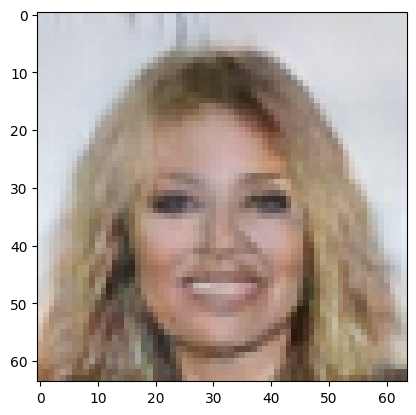

In [98]:
show_tensor_images(result, num_images=1, size=(3, 64, 64), nrow=1, outdir=None, epoch=1)